# tinycodec

This notebook will track my experiments with video encoding and developing the tinycodec software/hardware codec.

**Resources**
- [H264 Book](https://last.hit.bme.hu/download/vidtech/k%C3%B6nyvek/Iain%20E.%20Richardson%20-%20H264%20(2nd%20edition).pdf)
- [Digital Video Introduction](https://github.com/leandromoreira/digital_video_introduction)
- [A FPGA Based Design of a Multiplierless and Fully Pipelined JPEG Compressor](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1559802)

## Frames

In [1]:
import ffmpeg
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Math
from IPython.display import display
import cv2

%matplotlib inline

In [2]:
def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: ndarray
    :return: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = ['  ' + ' & '.join(l.split()) for l in lines]
    return r'\begin{bmatrix}' +  '\\\\ \n'.join(rv) + r'\end{bmatrix}'

def show(a, name="A"):
    display(Math(f"\\begin{{align}}{name} = {(bmatrix(a))}\\end{{align}}"))

In [3]:
def get_video_stats(filename):
    probe = ffmpeg.probe(filename)
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
    if video_stream:
        return int(video_stream['width']), int(video_stream['height']), int(video_stream['avg_frame_rate'].split('/')[0])
    else:
        return None, None, None

def frame(i):
    width, height, fps = get_video_stats('data/test.mov')
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i/fps)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

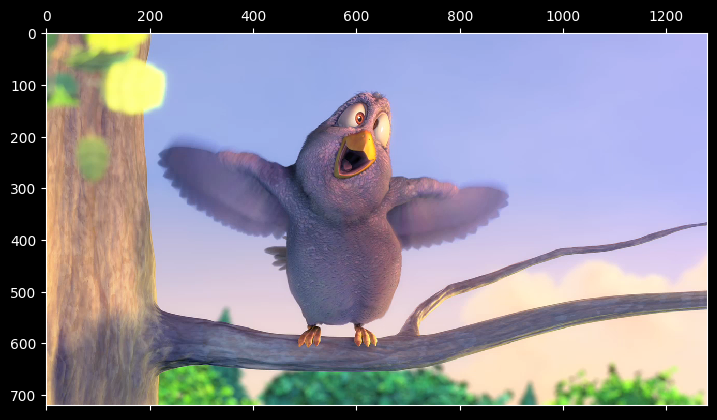

In [4]:
N, i, j = 482, 43, 14
plt.matshow(frame(N));

## Chroma Subsampling

In [5]:
def subsample(yuv: np.ndarray) -> np.ndarray:
    X = yuv.copy()
    X[:,:,1] = yuv[::2,::2,1].repeat(2, axis=0).repeat(2, axis=1)
    X[:,:,2] = yuv[::2,::2,2].repeat(2, axis=0).repeat(2, axis=1)
    return X

def rgb2yuv(rgb):
    yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)
    return subsample(yuv.astype(np.uint8))

In [6]:
def yuv2rgb(yuv):
    rgb = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    return rgb.astype(np.uint8)

In [7]:
def plot_yuv(yuv):
    y = yuv[:,:,0]
    u = yuv[:,:,1]
    v = yuv[:,:,2]
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(u, label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(v, label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

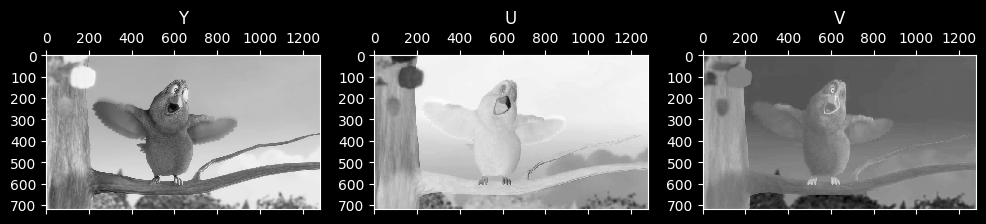

In [8]:
plot_yuv(rgb2yuv(frame(N)))

## Macroblocks

In [9]:
def macroblock(x, i, j):
    return x[i*16:(i+1)*16, j*16:(j+1)*16]

In [10]:
def plot_macroblock(mb):
    _, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(mb[:,:,0], label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(mb[::2,::2,1], label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(mb[::2,::2,2], label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

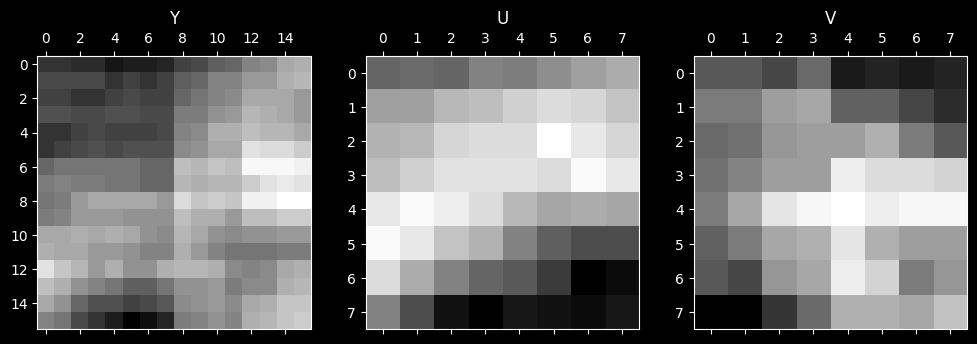

In [11]:

mb = macroblock(frame(N), i, j)
plot_macroblock(mb)

## Motion Compensation

In [12]:
def predict(reference_frame, current_frame, i, j):
    h, w = reference_frame.shape[0] // 16, reference_frame.shape[1] // 16
    ci, cj = i, j
    current_block = macroblock(current_frame, i, j)

    mv = ci,cj
    min_cost = np.sum(np.abs(current_block[:,:,0]))
    step_size = 16

    for step in range(4):
        if step == 3:
            step_size = 1

        for di in (-step_size, 0, step_size):
            for dj in (-step_size, 0, step_size):
                ni = ci + di
                nj = cj + dj

                if 0 <= ni < h and 0 <= nj < w:
                    candidate_block = macroblock(reference_frame, ni, nj)
                    cost = np.sum(np.abs(current_block[:,:,0] - candidate_block[:,:,0]))

                    if cost < min_cost:
                        min_cost = cost
                        mv = (ni, nj)

        ci, cj = mv
        step_size //= 2

    return mv

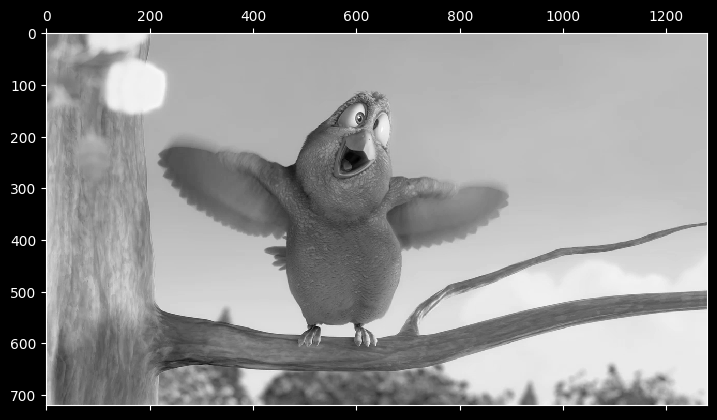

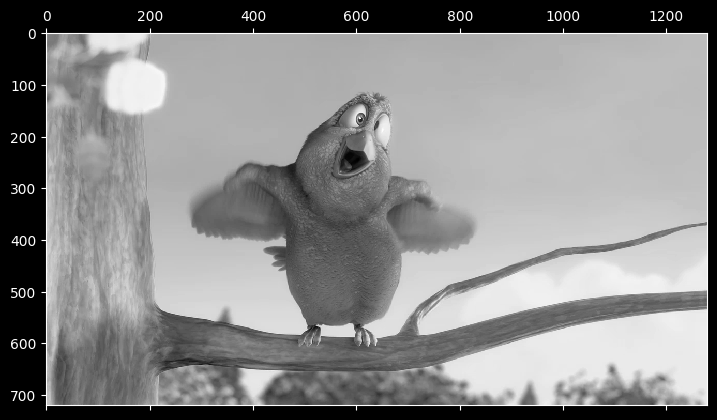

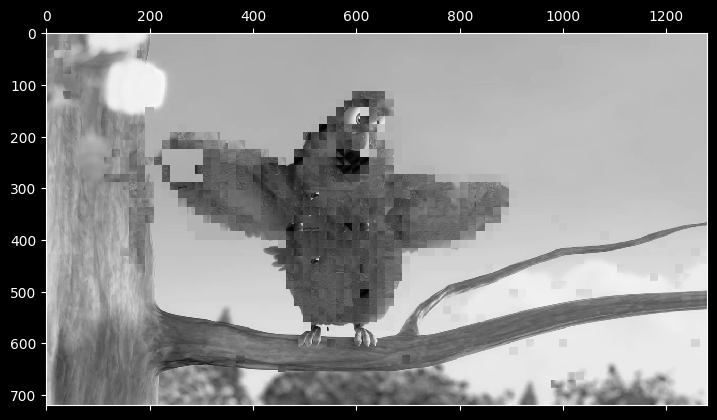

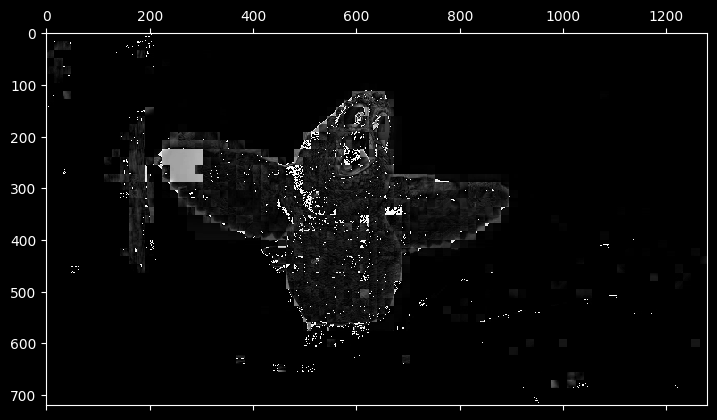

In [13]:
current_frame = rgb2yuv(frame(N))
reference_frame = rgb2yuv(frame(N-1))

plt.matshow(current_frame[:,:,0], cmap='gray')
plt.matshow(reference_frame[:,:,0], cmap='gray')

predicted_frame = np.zeros(current_frame.shape, dtype=np.uint8)
residual_frame = np.zeros(current_frame.shape, dtype=np.uint8)

w = current_frame.shape[1] // 16

for i in range(0, current_frame.shape[0] // 16):
    for j in range(0, current_frame.shape[1] // 16):
        ci, cj = predict(reference_frame, current_frame, i, j)
        B = macroblock(reference_frame, ci, cj)
        A = macroblock(current_frame, i, j)
        predicted_frame[(i*16):((i+1)*16), (j*16):((j+1)*16)] = B
        residual_frame[(i*16):((i+1)*16), (j*16):((j+1)*16)] = A - B

plt.matshow(predicted_frame[:,:,0], cmap='gray')
plt.matshow(residual_frame[:,:,0], cmap='gray');

## Forward Transform

In [14]:
block = macroblock(frame(N), i, j)

In [15]:
def fwd_transform(X: np.ndarray) -> np.ndarray:
    assert X.shape == (4, 4)
    QP = 6
    C = np.array([
        [1,1,1,1],
        [2,1,-1,-2],
        [1,-1,-1,1],
        [1,-2,2,-1]
    ])
    M = np.array([
        [13107,8066,13107,8066],
        [8066,5243,8066,5243],
        [13107,8066,13107,8066],
        [8066,5243,8066,5243]
    ])
    return np.round(((C @ X @ C.T) * M) / 2**(15+QP//6))

In [16]:
def fwd_transform_plane(luma: np.ndarray) -> np.ndarray:
    assert luma.shape == (16, 16)
    out = np.zeros_like(luma, dtype=np.float64)
    for i in range(4):
        for j in range(4):
            out[i*4:(i+1)*4,j*4:(j+1)*4] = fwd_transform(luma[i*4:(i+1)*4, j*4:(j+1)*4])
    return out

def fwd_transform_block(block: np.ndarray) -> np.ndarray:
    assert block.shape == (16, 16, 3)
    return np.stack(
        [fwd_transform_plane(block[:,:,p]) for p in range(3)],
        axis=-1
    ).astype(np.int16)

In [24]:
Y = fwd_transform_block(block)

## Inverse Transform

In [18]:
def inv_transform(Y: np.ndarray) -> np.ndarray:
    assert Y.shape == (4, 4)
    QP = 6
    C = np.array([
        [1,1,1,1],
        [1,1/2,1/2,-1],
        [1,-1,-1,1],
        [1/2,-1,1,-1/2]
    ])
    V = np.array([
        [10,13,10,13],
        [13,16,13,16],
        [10,13,10,13],
        [13,16,13,16],
    ])
    return np.round((C.T @ (Y * 2**(QP/6) * V) @ C) / 2**6)

In [19]:
def inv_transform_plane(luma: np.ndarray) -> np.ndarray:
    assert luma.shape == (16, 16)
    out = np.zeros_like(luma, dtype=np.float64)
    for i in range(4):
        for j in range(4):
            out[i*4:(i+1)*4,j*4:(j+1)*4] = inv_transform(luma[i*4:(i+1)*4, j*4:(j+1)*4])
    return out

def inv_transform_block(block: np.ndarray) -> np.ndarray:
    assert block.shape == (16, 16, 3)
    return np.stack(
        [inv_transform_plane(block[:,:,p]) for p in range(3)],
        axis=-1
    ).astype(np.uint8)

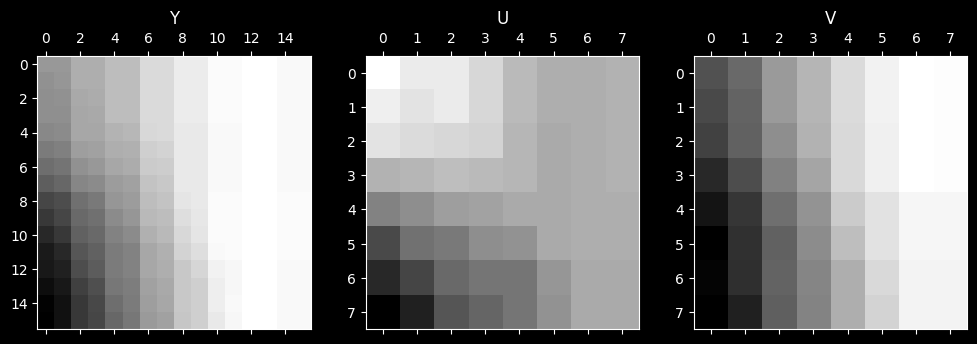

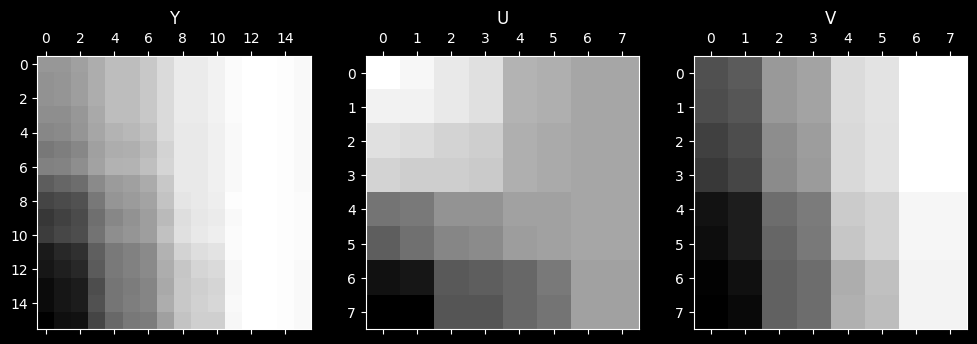

In [25]:
X = inv_transform_block(Y)

plot_macroblock(block)
plot_macroblock(X)

In [26]:
def quantize_frame(N):
    F = frame(N)
    plt.matshow(F)
    yuv = rgb2yuv(F)
    out = np.zeros_like(yuv, dtype=np.uint8)
    for i in range(0, yuv.shape[0], 16):
        for j in range(0, yuv.shape[1], 16):
            out[i:i+16,j:j+16] = inv_transform_block(
                fwd_transform_block(yuv[i:i+16,j:j+16])
            )
    G = yuv2rgb(out)
    plt.matshow(G)
    return G

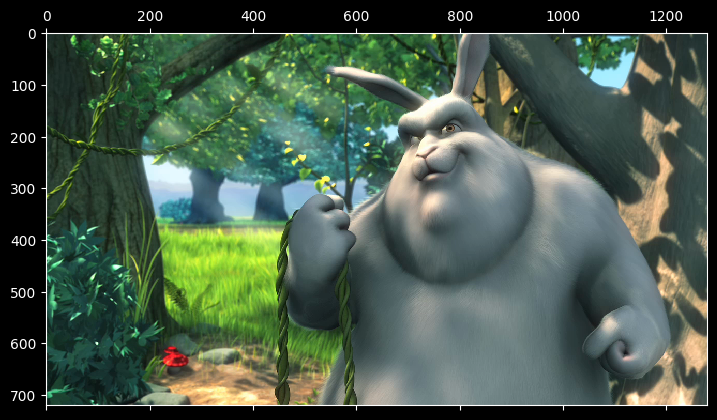

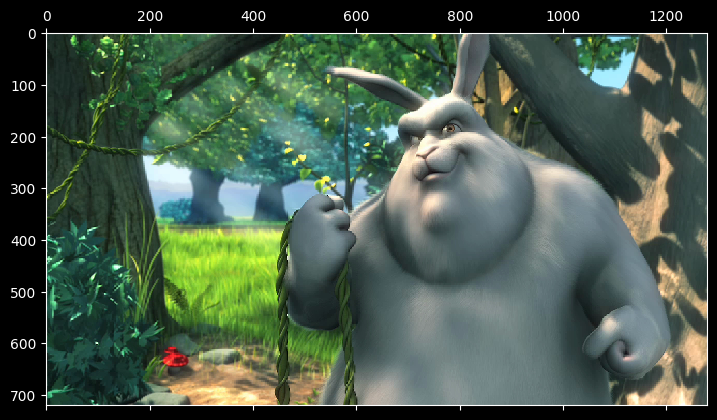

In [27]:
G = quantize_frame(6000)

## Zigzag Scanning

In [51]:
def block_scan_4x4(block: np.ndarray) -> np.ndarray:
    x = np.zeros(16)
    x[0] = block[0,0]
    x[1] = block[0,1]
    x[2] = block[1,0]
    x[3] = block[2,0]
    x[4] = block[1,1]
    x[5] = block[0,2]
    x[6] = block[0,3]
    x[7] = block[1,2]
    x[8] = block[2,1]
    x[9] = block[3,0]
    x[10] = block[3,1]
    x[11] = block[2,2]
    x[12] = block[1,3]
    x[13] = block[2,3]
    x[14] = block[3,2]
    x[15] = block[3,3]
    return x

def block_scan_16x16(block: np.ndarray) -> np.ndarray:
    x = np.zeros((16,16))
    x[0] = block_scan_4x4(block[0:4,0:4])
    x[1] = block_scan_4x4(block[0:4,4:8])
    x[2] = block_scan_4x4(block[4:8,0:4])
    x[3] = block_scan_4x4(block[4:8,4:8])
    x[4] = block_scan_4x4(block[0:4,8:12])
    x[5] = block_scan_4x4(block[0:4,12:16])
    x[6] = block_scan_4x4(block[4:8,8:12])
    x[7] = block_scan_4x4(block[4:8,12:16])
    x[8] = block_scan_4x4(block[8:12,0:4])
    x[9] = block_scan_4x4(block[8:12,4:8])
    x[10] = block_scan_4x4(block[12:16,0:4])
    x[11] = block_scan_4x4(block[12:16,4:8])
    x[12] = block_scan_4x4(block[8:12,8:12])
    x[13] = block_scan_4x4(block[8:12,12:16])
    x[14] = block_scan_4x4(block[12:16,8:12])
    x[15] = block_scan_4x4(block[12:16,12:16])
    return x.reshape(-1)

def block_scan_8x8(block: np.ndarray) -> np.ndarray:
    x = np.zeros((4,16))
    x[0] = block_scan_4x4(block[0:4,0:4])
    x[1] = block_scan_4x4(block[0:4,4:8])
    x[2] = block_scan_4x4(block[4:8,0:4])
    x[3] = block_scan_4x4(block[4:8,4:8])
    return x.reshape(-1)

def block_scan_yuv(block: np.ndarray) -> np.ndarray:
    return (
            block_scan_16x16(block[:,:,0]).astype(np.int16),
            block_scan_8x8(block[::2,::2,1]).astype(np.int16),
            block_scan_8x8(block[::2,::2,2]).astype(np.int16)
        )

In [52]:
y_scan, u_scan, v_scan = block_scan_yuv(Y)
y_scan

array([676, -17,   4,   0,   1,   0,   5,   0,   1,   0,   0,   1,   0,
         0,   0,   0, 741, -19,   0,   0,   0,   0,   6,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 642, -24,  18,  -1,   2,  -1,   5,
         0,   0,   3,   1,   0,   1,   0,   0,   0, 720, -25,  11,   0,
         1,   0,   6,   0,  -1,   2,   1,   0,   0,   0,   0,   0, 798,
       -10,   0,   0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 811,   4,   0,   0,   0,   0,  -1,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 795, -10,   0,   0,   0,   0,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 811,   4,   0,   0,   0,
         0,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0, 561, -35,
        17,  -1,   4,  -1,   4,   1,   0,   2,   0,   1,   0,   0,   0,
         0, 679, -31,  12,   0,   2,   0,   5,  -1,   1,   2,   0,   1,
         0,   0,   1,   0, 509, -40,  11,   4,   0,   1,   3,   1,   0,
         1,  -1,   0,   1,   0,   0,   0, 651, -32,   7,   0,   

## Entropy Encoding

In [64]:
def run_length_encoding(x: np.ndarray) -> np.ndarray:
    y = []
    zero_count = 0

    for v in x:
        if v == 0:
            zero_count += 1
        else:
            y.append([zero_count, v, 0])
            zero_count = 0

    y[-1][2] = 1

    return np.array(y)

In [67]:
y_rle = run_length_encoding(y_scan)
y_rle

array([[  0, 676,   0],
       [  0, -17,   0],
       [  0,   4,   0],
       [  1,   1,   0],
       [  1,   5,   0],
       [  1,   1,   0],
       [  2,   1,   0],
       [  4, 741,   0],
       [  0, -19,   0],
       [  4,   6,   0],
       [  9, 642,   0],
       [  0, -24,   0],
       [  0,  18,   0],
       [  0,  -1,   0],
       [  0,   2,   0],
       [  0,  -1,   0],
       [  0,   5,   0],
       [  2,   3,   0],
       [  0,   1,   0],
       [  1,   1,   0],
       [  3, 720,   0],
       [  0, -25,   0],
       [  0,  11,   0],
       [  1,   1,   0],
       [  1,   6,   0],
       [  1,  -1,   0],
       [  0,   2,   0],
       [  0,   1,   0],
       [  5, 798,   0],
       [  0, -10,   0],
       [  4,   3,   0],
       [  9, 811,   0],
       [  0,   4,   0],
       [  4,  -1,   0],
       [  9, 795,   0],
       [  0, -10,   0],
       [  4,   3,   0],
       [  9, 811,   0],
       [  0,   4,   0],
       [  4,  -1,   0],
       [  9, 561,   0],
       [  0, -35